In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import SGD 
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline


In [2]:
sentence = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'

In [3]:
class WordDataSet:
    
    def __init__(self, sentence):
        self.words2idx = {}
        self.indexs  = []
        for word in sentence.split(' '): 
            if word not in self.words2idx:
                self.words2idx[word] = len(self.words2idx)
                
            self.indexs.append(self.words2idx[word])
            
        self.vec_size = len(self.words2idx)
        self.seq_len  = len(sentence.split(' '))
        
    def get_one_hot(self, idx):
        x = torch.zeros(self.vec_size)
        x[idx] = 1
        return x
    
    def __iter__(self):
        return zip(self.indexs[:-1], self.indexs[1:])
    
    def __len__(self):
        return self.seq_len
    
    def size(self):
        return len(self.words2idx)
    
    def get_char_by_id(self, id):
        for word, i in self.words2idx.items():
            if id == i: return word
        return None

In [4]:
class VanillaRNN(nn.Module):
    
    def __init__(self, in_size=5, h_size=2, c_size=2, out_size=5):
        super(VanillaRNN, self).__init__()
        self.x2hidden    = nn.Linear(in_features=in_size, out_features=hidden_size)
        self.hidden      = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.activation  = nn.Tanh()
        self.outweight   = nn.Linear(in_features=hidden_size, out_features=out_size)
    
    def forward(self, x, prev_hidden):
        hidden = self.x2hidden(x) + self.hidden(prev_hidden)
        output = self.outweight(hidden)
        return output, hidden

In [5]:
class LSTM(nn.Module):
    
    def __init__(self, size=5, h_size=5):
        super(LSTM, self).__init__()
        self.W_f = nn.Linear(in_features = size+h_size, out_features = h_size)
        self.W_i = nn.Linear(in_features = size+h_size, out_features = h_size)
        self.W_g = nn.Linear(in_features = size+h_size, out_features = h_size)
        self.W_o = nn.Linear(in_features = size+h_size, out_features = h_size)
        
        self.S_f = nn.Sigmoid()
        self.S_i = nn.Tanh()
        self.T_g = nn.Sigmoid()
        self.S_o = nn.Sigmoid()
        
        self.T_c = nn.Tanh()
        
        self.output = nn.Linear(in_features = h_size, out_features = size)
        
    def forward(self, x, prev_h, prev_c):
        stack = torch.cat((x, prev_h), 1)
        
        f = self.S_f(self.W_f(stack))
        i = self.S_i(self.W_i(stack))
        g = self.T_g(self.W_g(stack))
        o = self.S_o(self.W_o(stack))
        
        c = f*prev_c + i*g
        h = o*self.T_c(prev_c)
        
        output = self.output(h)
        
        return output, h, c
        

In [6]:
ds = WordDataSet(sentence=sentence)
lstm = LSTM(ds.size(),5)
criterion = nn.CrossEntropyLoss()
e_cnt     = 1000
optim     = SGD(lstm.parameters(), lr = 0.05)

lr_lambda = lambda epoch : 0.99**(epoch/10)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optim, lr_lambda=lr_lambda)

# Обучение

In [7]:
losses = []
for epoch in range(e_cnt):
    scheduler.step()
    h = Variable( torch.zeros(5) ).unsqueeze(0)
    c = Variable( torch.zeros(5) ).unsqueeze(0)
    loss = 0
    optim.zero_grad()
    for sample, next_sample in ds:
        x = Variable(  ds.get_one_hot(sample) ).unsqueeze(0)
        target =  Variable(torch.LongTensor([next_sample]) )

        y, h, c = lstm(x, h, c)
        
        loss += criterion(y, target)
     
    if epoch % 25 == 0:
        print (loss.data[0])
        
    loss.backward()
    losses.append(loss.data[0])
    optim.step()

286.0835266113281
276.5696105957031
257.2555847167969
210.14503479003906
149.62301635742188
115.86869049072266
91.32355499267578
77.24639129638672
67.78730773925781
59.48353576660156
53.86800765991211
48.780250549316406
45.63456344604492
41.672706604003906
38.97775650024414
36.38735580444336
34.295166015625
32.41567611694336
30.733882904052734
29.14373207092285
27.692644119262695
26.43338394165039
25.40239715576172
24.276599884033203
23.25018310546875
22.361509323120117
21.656862258911133
20.880945205688477
20.193389892578125
19.586135864257812
19.029150009155273
18.515949249267578
18.04141616821289
17.600807189941406
17.189987182617188
16.805889129638672
16.446002960205078
16.108152389526367
15.790385246276855
15.49095630645752


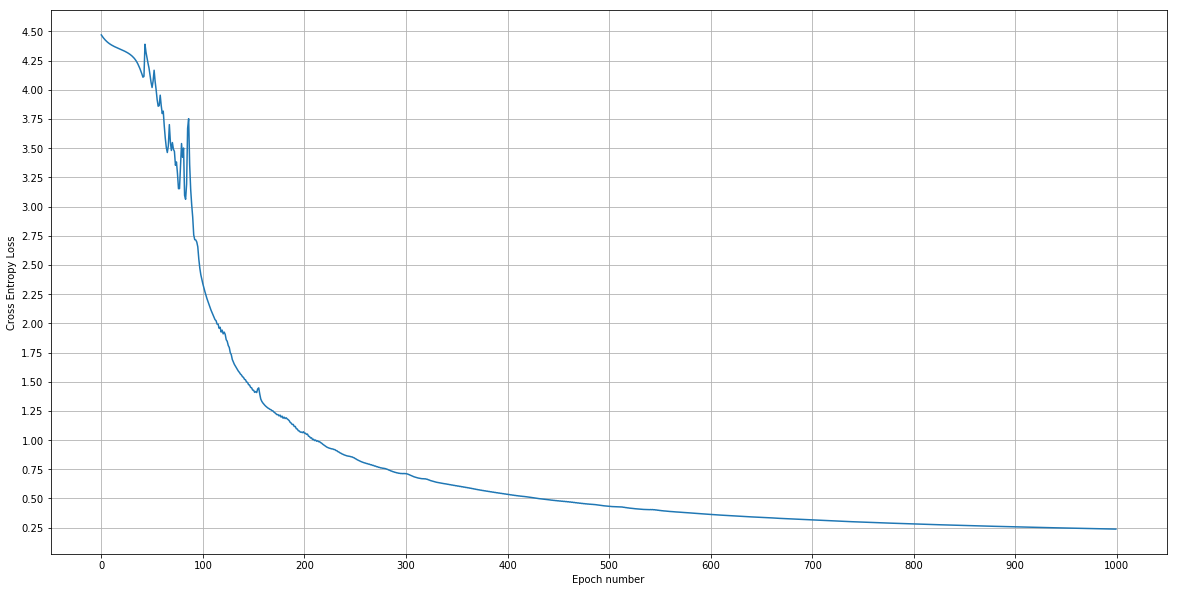

In [22]:
fig = plt.figure(figsize=(20,10))

ax = fig.gca()
ax.set_xticks(np.arange(0, 1100, 100))
ax.set_yticks(np.arange(0, 5, 0.25))
plt.plot(np.array(losses)/ds.size())
plt.grid()

plt.xlabel("Epoch number")
plt.ylabel("Cross Entropy Loss")

plt.savefig("Cross_Entropy_Loss.png")

# Тестирование

In [185]:
lstm.eval()
h = Variable( torch.zeros(5) ).unsqueeze(0)
c = Variable( torch.zeros(5) ).unsqueeze(0)
id = 0
softmax = nn.Softmax()
predsentence = ds.get_char_by_id(id) + ' '
for w in range(len(ds)-1):
    x = Variable(ds.get_one_hot(id)).unsqueeze(0)
    y, h, c = lstm(x, h, c)
    y = softmax(y)
    m, id = torch.max(y, 1)
    id = id.data[0]
    predsentence += ds.get_char_by_id(id) + ' '
print ('Prediction: ' , predsentence)

Prediction:  Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum. 


/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
